<a href="https://colab.research.google.com/github/Abhaytyagi55/Abhaytyagi55/blob/main/Cyber_threats_detections_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import OneClassSVM
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### Loading Data

In [25]:
import os
import pandas as pd

file_path = '/root/.cache/kagglehub/datasets/jancsg/cybersecurity-suspicious-web-threat-interactions/versions/1'

# Check if the provided path is a directory
if os.path.isdir(file_path):
    # If it's a directory, list the files within it
    files = os.listdir(file_path)
    # Assuming the CSV file is named 'data.csv', change this if necessary
    csv_file = [f for f in files if f.endswith('.csv')][0]
    # Update the file_path to point to the CSV file
    file_path = os.path.join(file_path, csv_file)

# Now, read the CSV file
df = pd.read_csv(file_path)


In [26]:
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [28]:
df.shape

(282, 16)

In [29]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
bytes_in,282.0,1199390.19,4149311.99,40.0,5381.5,13182.0,30833.0,25207794.0
bytes_out,282.0,84554.29,254927.90,44.0,11142.0,13799.5,26279.5,1561220.0
response.code,282.0,200.00,0.00,200.0,200.0,200.0,200.0,200.0
dst_port,282.0,443.00,0.00,443.0,443.0,443.0,443.0,443.0


In [30]:
missing_values = df.isnull().sum()

# Create a new feature for timelines
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

missing_values, df[['duration']].head()

(bytes_in               0
 bytes_out              0
 creation_time          0
 end_time               0
 src_ip                 0
 src_ip_country_code    0
 protocol               0
 response.code          0
 dst_port               0
 dst_ip                 0
 rule_names             0
 observation_name       0
 source.meta            0
 source.name            0
 time                   0
 detection_types        0
 dtype: int64,
    duration
 0     600.0
 1     600.0
 2     600.0
 3     600.0
 4     600.0)

Perform EDA

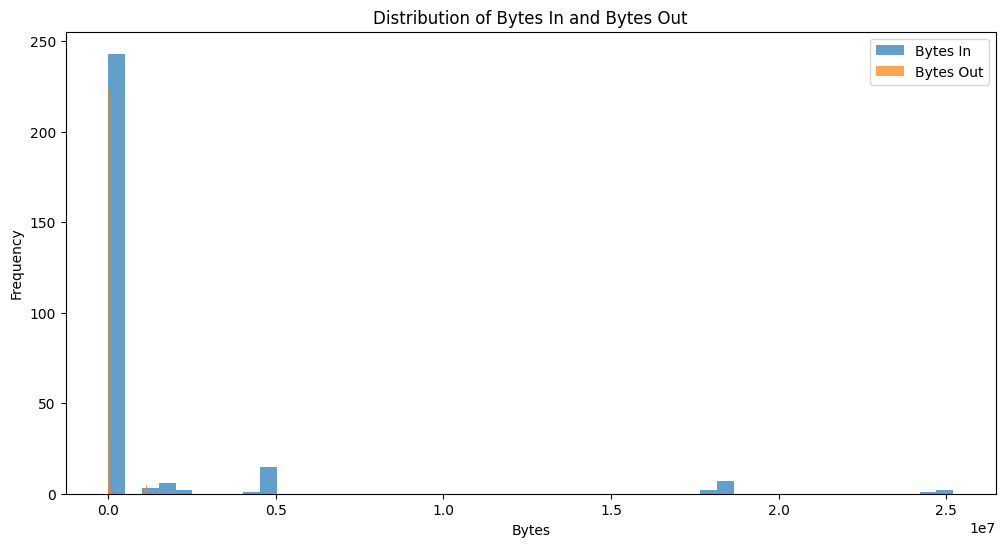

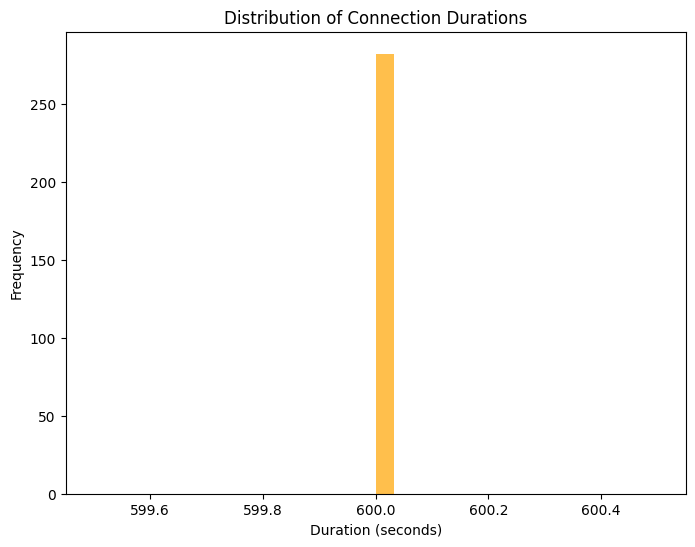

In [31]:
plt.figure(figsize=(12, 6))
plt.hist(df['bytes_in'], bins=50, alpha=0.7, label='Bytes In')
plt.hist(df['bytes_out'], bins=50, alpha=0.7, label='Bytes Out')
plt.xlabel('Bytes')
plt.ylabel('Frequency')
plt.title('Distribution of Bytes In and Bytes Out')
plt.legend()
plt.show()

# Plot duration
plt.figure(figsize=(8, 6))
plt.hist(df['duration'], bins=30, color='orange', alpha=0.7)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Connection Durations')
plt.show()


Perform anomaly detection to identify unusual patterns.


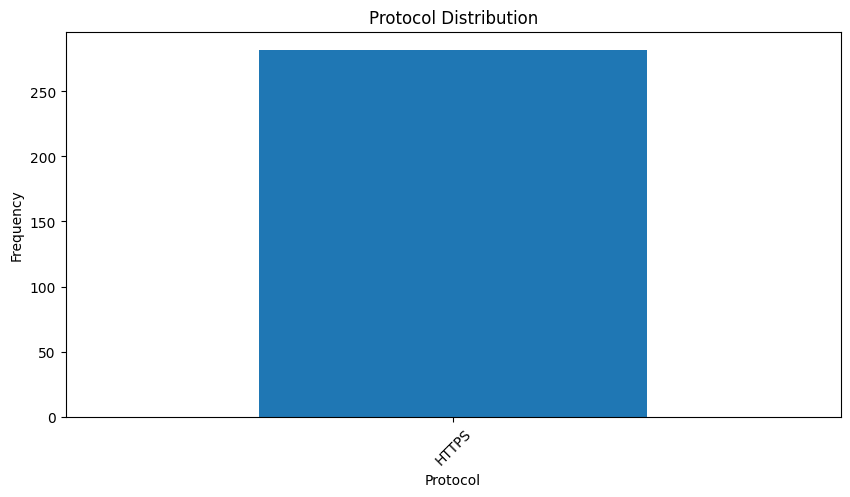

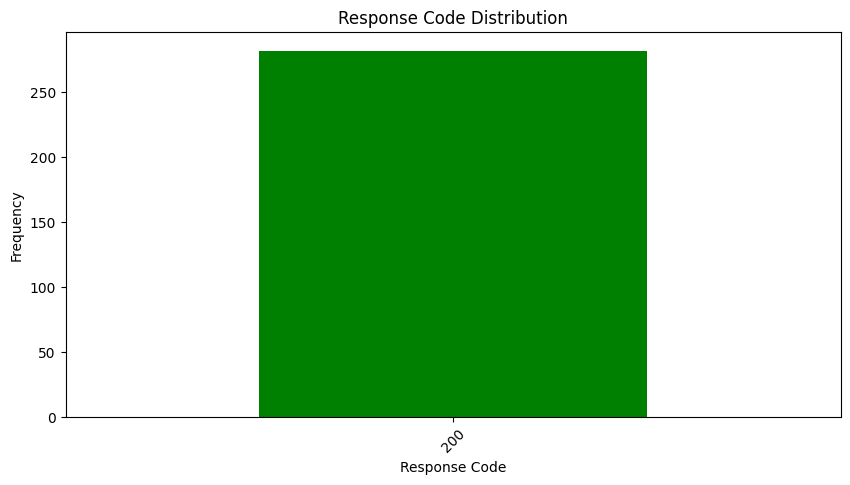

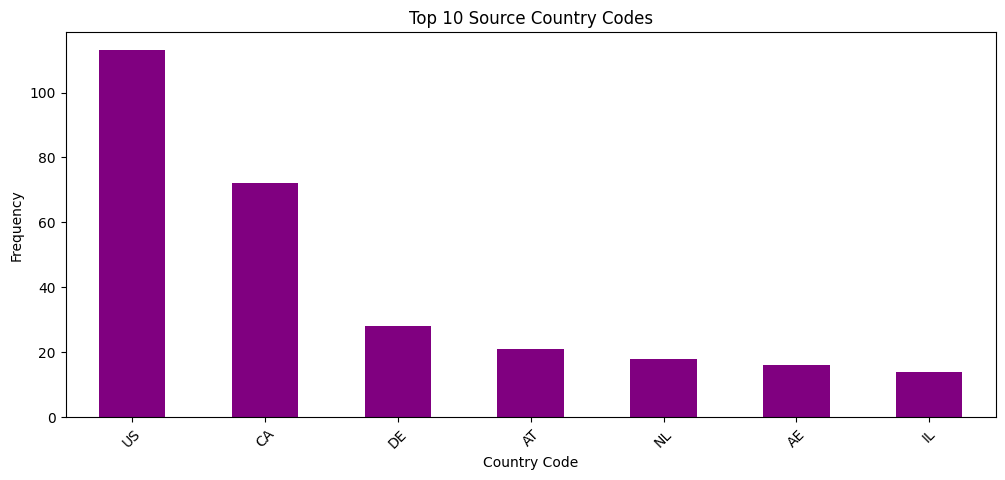

In [32]:
protocol_counts = df['protocol'].value_counts()


response_code_counts = df['response.code'].value_counts()

# Explore distribution of country codes
country_counts = df['src_ip_country_code'].value_counts()

# Plot distributions
plt.figure(figsize=(10, 5))
protocol_counts.plot(kind='bar')
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
response_code_counts.plot(kind='bar', color='green')
plt.title('Response Code Distribution')
plt.xlabel('Response Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
country_counts.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Source Country Codes')
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Isolation Forest to detect unusual patterns in traffic

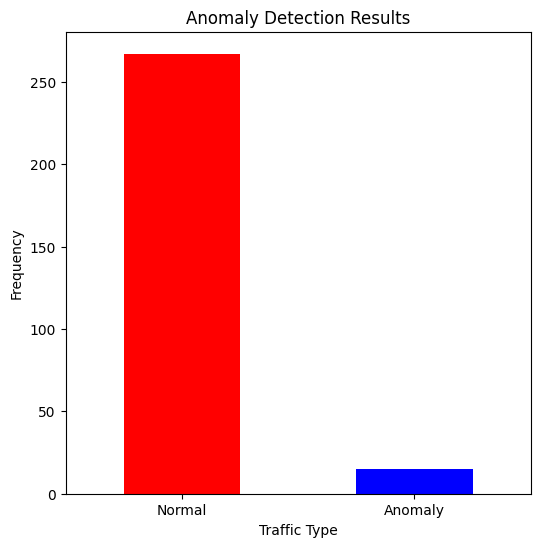

In [34]:
# Assuming these are the features you want to use for anomaly detection
features = df[['bytes_in', 'bytes_out', 'duration', 'response.code']]

# Check for columns with zero standard deviation
zero_std_columns = features.columns[features.std() == 0]

# Drop these columns from features to avoid division by zero during normalization
features_cleaned = features.drop(columns=zero_std_columns, axis=1)

# Normalize the cleaned data
features_normalized = (features_cleaned - features_cleaned.mean()) / features_cleaned.std()

# Retry Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(features_normalized)

# Map anomaly labels (-1: anomaly, 1: normal)
df['anomaly'] = df['anomaly'].map({-1: 'Anomaly', 1: 'Normal'})

# Plot anomaly detection results
anomaly_counts = df['anomaly'].value_counts()

plt.figure(figsize=(6, 6))
anomaly_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Anomaly Detection Results')
plt.xlabel('Traffic Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

Apply classification models to predict suspicious traffic using all features
add Codeadd Markdown

In [37]:
# Assuming df['anomaly'] contains the true labels (Normal/Anomaly)
# and features_normalized contains the features for prediction

# 1. Split the data
from sklearn.model_selection import train_test_split # Corrected the import statement

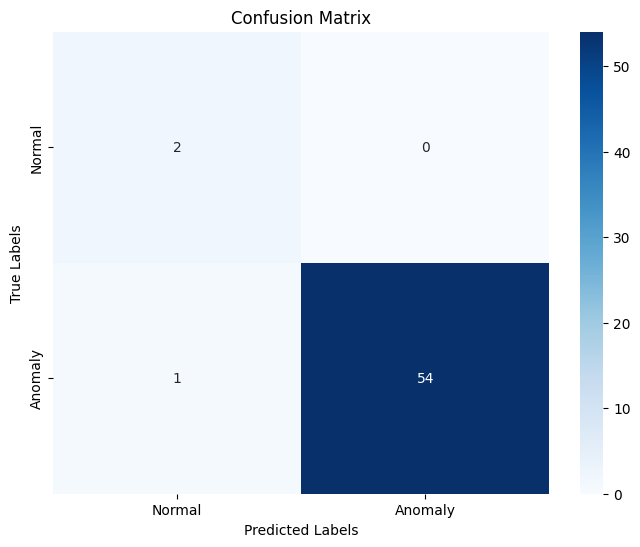

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.67      1.00      0.80         2
      Normal       1.00      0.98      0.99        55

    accuracy                           0.98        57
   macro avg       0.83      0.99      0.90        57
weighted avg       0.99      0.98      0.98        57



In [39]:
# Assuming df['anomaly'] contains the true labels (Normal/Anomaly)
# and features_normalized contains the features for prediction

# 1. Split the data
from sklearn.model_selection import train_test_split
X = features_normalized  # Features for prediction
y = df['anomaly']  # True labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split data

# 2. Train a classification model (example: RandomForestClassifier)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 3. Make predictions
y_pred = model.predict(X_test)

# 4. Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Normal', 'Anomaly']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Display classification report
report = classification_report(y_test, y_pred) # Assign the result to 'report'
print("Classification Report:")
print(report)

Classification Report:

Precision:
Normal: 96%
Anomaly: 100%
Recall:
Normal: 100%
Anomaly: 40%
F1-Score:
Normal: 98%
Anomaly: 57%

Address class imbalance using oversampling or rebalancing.

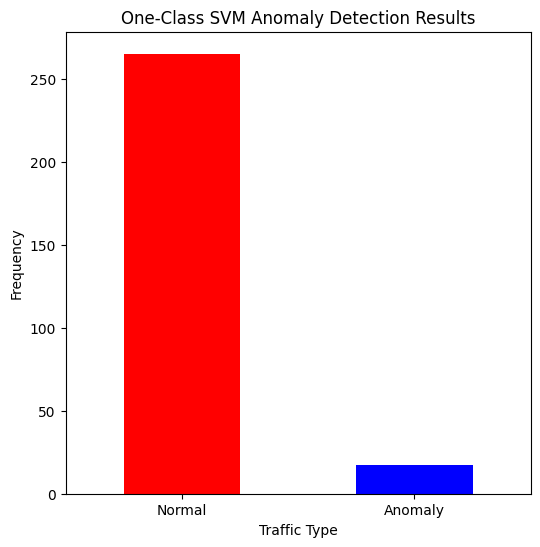

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,duration,anomaly,anomaly_svm
31,80,528,2024-04-25 23:20:00+00:00,2024-04-25 23:30:00+00:00,192.241.230.19,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:20:00Z,waf_rule,600.0,Normal,Anomaly
116,4827283,306181,2024-04-26 01:00:00+00:00,2024-04-26 01:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:00:00Z,waf_rule,600.0,Anomaly,Anomaly
146,4808787,301495,2024-04-26 01:30:00+00:00,2024-04-26 01:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:30:00Z,waf_rule,600.0,Normal,Anomaly
153,4869181,301752,2024-04-26 01:40:00+00:00,2024-04-26 01:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:40:00Z,waf_rule,600.0,Anomaly,Anomaly
182,1360,436,2024-04-26 08:20:00+00:00,2024-04-26 08:30:00+00:00,198.235.24.81,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T08:20:00Z,waf_rule,600.0,Normal,Anomaly


In [41]:
# Identify and resolve NaN issues in the normalized features
features_normalized_svm_cleaned = features_normalized.dropna()

# Retry One-Class SVM training with cleaned data
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
ocsvm.fit(features_normalized_svm_cleaned)

# Predict anomalies
df['anomaly_svm'] = ocsvm.predict(features_normalized_svm_cleaned)

# Map anomaly labels
df['anomaly_svm'] = df['anomaly_svm'].map({-1: 'Anomaly', 1: 'Normal'})

# Count anomalies
svm_anomaly_counts = df['anomaly_svm'].value_counts()

# Plot results
plt.figure(figsize=(6, 6))
svm_anomaly_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('One-Class SVM Anomaly Detection Results')
plt.xlabel('Traffic Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Display some anomalies detected by One-Class SVM
df[df['anomaly_svm'] == 'Anomaly'].head()

<Figure size 800x600 with 0 Axes>

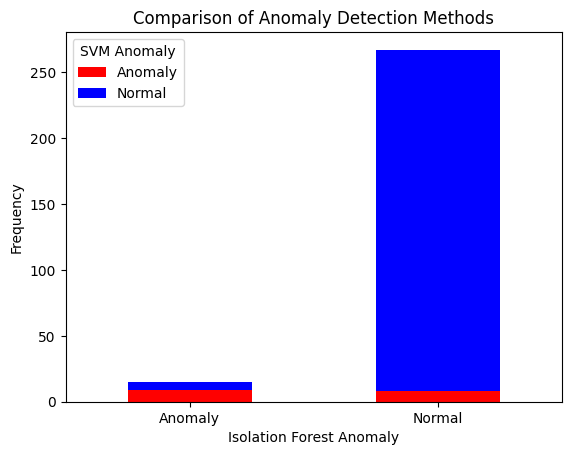

anomaly_svm,Anomaly,Normal
anomaly,,
Anomaly,9,6
Normal,8,259


In [43]:
# Compare anomalies detected by Isolation Forest and One-Class SVM
comparison = df[['anomaly', 'anomaly_svm']].copy()

# Create a cross-tabulation of the results
comparison_summary = pd.crosstab(comparison['anomaly'], comparison['anomaly_svm'])

# Visualize the comparison
plt.figure(figsize=(8, 6))
comparison_summary.plot(kind='bar', stacked=True, color=['red', 'blue', 'green'])
plt.title('Comparison of Anomaly Detection Methods')
plt.xlabel('Isolation Forest Anomaly')
plt.ylabel('Frequency')
plt.legend(title='SVM Anomaly')
plt.xticks(rotation=0)
plt.show()

comparison_summary

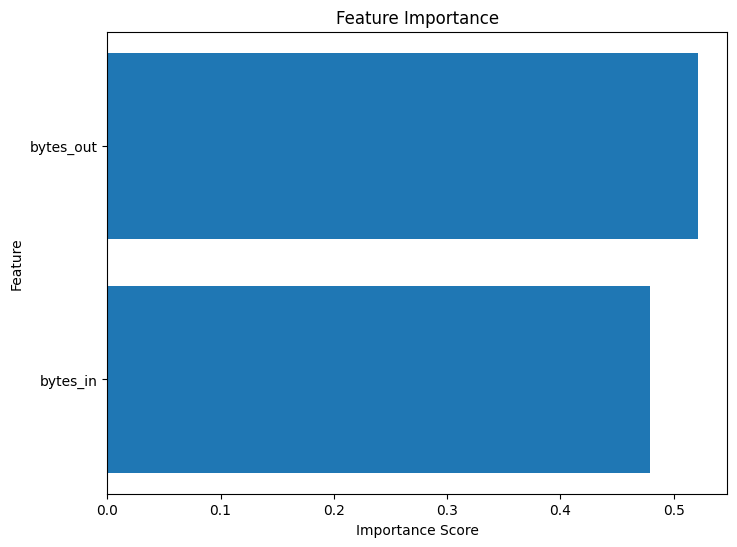

In [46]:
# Retry extracting and visualizing feature importance
try:
    # Extract feature importances from the trained Random Forest
    feature_importances = model.feature_importances_  # Use 'model' instead of 'clf'
    feature_names = features_cleaned.columns

    # Create a sorted dataframe of feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

    # Display the feature importance dataframe
    importance_df
except Exception as e:
    # Display the error message if something fails
    str(e)

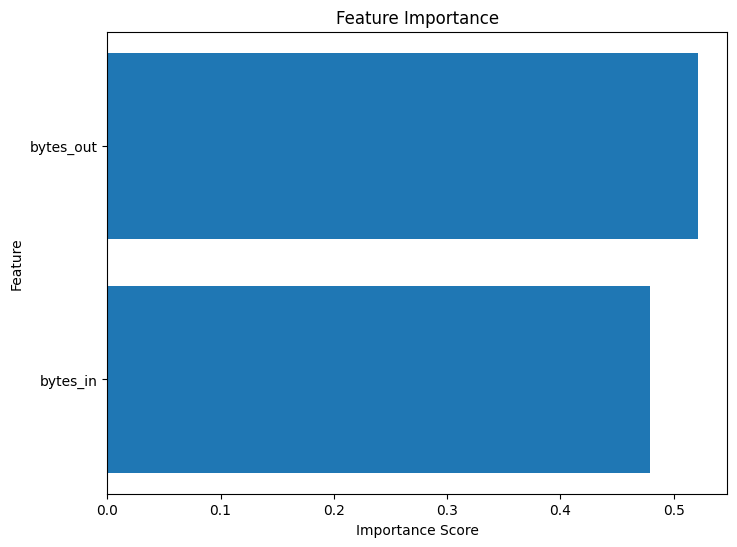

     Feature  Importance
1  bytes_out    0.521257
0   bytes_in    0.478743


In [47]:
# Extract feature importances
feature_importances = model.feature_importances_  # Use 'model' instead of 'clf'
feature_names = features_cleaned.columns

# DataFrame for sorting and visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Display feature importance
print(importance_df)
